In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import matplotlib.ticker as ticker
import math

In [8]:
class BlackScholes:
    def __init__(self, S : np.ndarray, K =100.0, sigma : float = 0.1, r : float = 0.05, q : float = 0.05, T : int = 1):
        self.S = S # Could be a float, or an array/list
        self.K = K
        self.sigma = sigma
        self.r = r
        self.q = q
        self.T = T
        
    def normparam(self, t:float = 0):
        if t == self.T:
            d1 = np.inf
            d2 = np.inf
        else:
            d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
            d2 = d1 - self.sigma * np.sqrt(self.T - t)
        return d1, d2
    
    def call(self, state:bool = True, t:float = 0) -> float:
        """
        Renvoie le prix d'un call en fonction de s'il s'agit du vendeur ou de l'acheteur
        """
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1]
        call_price_long = self.S*np.exp(-self.q* (self.T - t)) * norm.cdf(d1) - self.K*np.exp(-self.r * (self.T-t)) * norm.cdf(d2)
        if state:
            call_price = call_price_long
        else:
            call_price = -call_price_long
        return call_price
    
    def callpayoff(self, state:bool = True) -> float:
        long_call_payoff = np.maximum(self.S - self.K,0)
        if state:
            call_payoff = long_call_payoff
        else:
            call_payoff = -long_call_payoff
        return call_payoff

    def put(self, state: bool = True, t : float = 0):
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1]
        put_price_long = self.S*np.exp(-self.q* (self.T-t)) * (norm.cdf(d1)-1) - self.K*np.exp(-self.r * (self.T-t)) * (norm.cdf(d2)-1)
        if state:
            put_price = put_price_long
        else:
            put_price = - put_price_long
        return put_price
    
    def putpayoff(self, state : bool = True)->float:
        long_put_payoff = np.maximum(self.K - self.S,0)
        if state:
            put_payoff = long_put_payoff
        else:
            put_payoff = -long_put_payoff
        return put_payoff
    
    def delta(self, state : bool = True, t:float = 0, opt:bool = True) -> float:
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1]
        if state:
            if t != self.T:
                if opt:
                    delta = norm.cdf(d1)
                else:
                    delta = norm.cdf(d1)-1
            else:
                if self.callpayoff() > 0:
                    if opt:
                        delta = 1
                    else:
                        delta = 0
                else:
                    if opt:
                        delta = 0
                    else:
                        delta = -1
        else:
            if t != self.T:
                if opt:
                    delta = -norm.cdf(d1)
                else:
                    delta = -(norm.cdf(d1) - 1)
            else:
                if self.call_payoff() <= 0:
                    if opt:
                        delta = 0
                    else:
                        delta = 1
                else:
                    if opt:
                        delta = -1
                    else:
                        delta = 0
        return delta
    
    def gamma(self, state : bool = True, t:float = 0) -> float:
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1]
        scal = (self.S * self.sigma * np.sqrt(self.T-t))**(-1)
        if state:
            if t != self.T:
                gamma = scal * norm.pdf(d1) 
            else:
                gamma = 0
        else:
            if t != self.T:
                gamma = -scal * norm.pdf(d1)
            else:
                gamma = 0
        return gamma
    
    def vega(self, state : bool = True, t : float = 0) -> float:
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1]
        scal = self.S * np.sqrt(self.T - t)
        if state:
            vega = scal * norm.pdf(d1)
        else:
            vega = -scal * norm.pdf(d1)
        return vega
    
    def theta(self, state: bool = True, t : float = 0, opt : bool = True):
        """
        Renvoie le theta en fonction de t d'un call , si opt = True, et celui d'un put sinon 
        """
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1]
        
        A = -(self.S * norm.pdf(d1) * self.sigma)/(2*np.sqrt(self.T -t))
        B_call = - self.r*self.K*np.exp(-self.r * self.T) * norm.cdf(d2)
        B_put = self.r * self.K * np.exp(-self.r * self.T ) * norm.cdf(-d2)
        theta_call = A + B_call
        theta_put = A + B_put
        
        if state:
            if opt:
                theta = theta_call
            else:
                theta = theta_put
        else:
            if opt:
                theta = -theta_call
            else:
                theta = -theta_put
        return theta
    
    def rho(self, state:bool = True, t:float = 0, opt: bool = True):
        """
        Renvoie le rho d'un call si opt = True, et celui d'un put sinon
        Nous sommes coté vendeur si state est faux, et coté acheteur sinon
        """
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1]
        
        Rho_call = self.K*self.T * np.exp(-self.r*(self.T-t)) * norm.cdf(d2)
        Rho_put = -Rho_call
        if state:
            if opt:
                Rho = Rho_call
            else:
                Rho = Rho_put
        else:
            if opt:
                Rho = -Rho_call
            else:
                Rho = -Rho_put            
        return Rho
        
    def volga(self, state:bool = True, t:float = 0)-> float:
        """
        Le volga représenta la sensibilité à l'ordre 2 de l'option par rapport à la volatilité implicite
        Cette méthode renvoie le volga d'un call et d'un put.
        """
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1]        
        volg = np.exp(-self.q * t) * np.sqrt(self.T - t) * norm.pdf(d1) * (d1*d2)/self.sigma
        if state:
            volga = volg
        else:
            volga = -volg
            
        return volga
    
    def vanna(self, state:bool = True, t:float = 0)->float:
        d1 = self.normparam(t)[0]
        d2 = self.normparam(t)[1] 
        van = np.exp(-self.q*t) * np.sqrt(self.T-t) * norm.pdf(d1) * d2/self.sigma
        if state:
            vanna = van
        else:
            vanna = -van
            
        return vanna        
        

In [5]:
BS = BlackScholes(0.75, 1.0,0.2,0.0155,0.0243,0.0943)
put = BS.put()
put

0.24842526766599116

## Option's profit

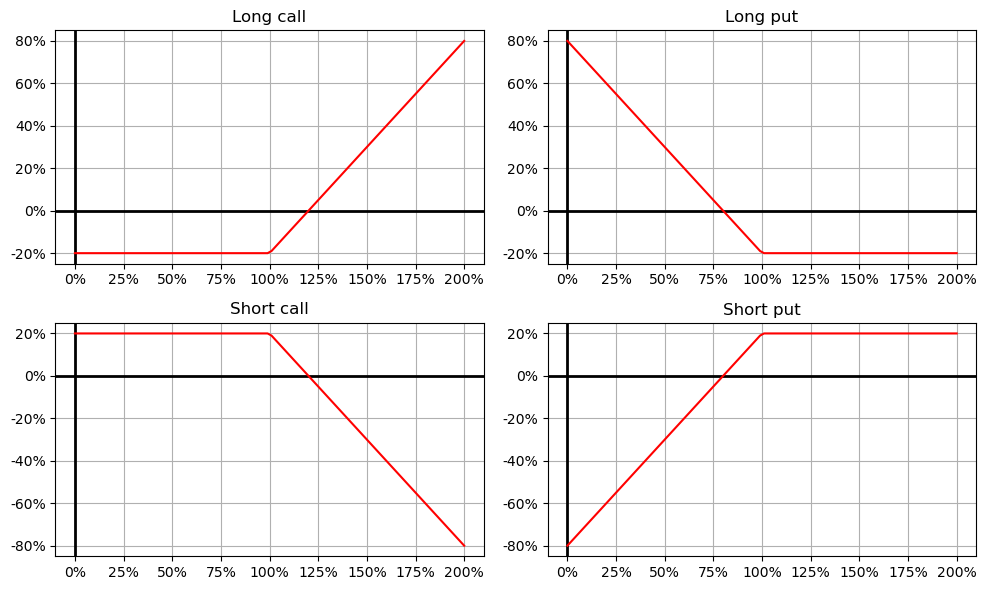

In [6]:
# variables
x = np.linspace(0,2,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)

def exprim_pourcentage(x:float, pos):
    val = x * 100
    return f"{val:.0f}%"

example_price = 0.2

BS = BlackScholes(x,1,0.1,0.05,0.05,1)
y1 = BS.callpayoff() - example_price
y2 = BS.putpayoff() - example_price
y3 = BS.callpayoff(False) + example_price
y4 = BS.putpayoff(False) + example_price

# Création de la figure et des sous-graphiques
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="r")
ax1.set_title('Long call')
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(x, y2,c="r")
ax2.set_title('Long put')
ax2.grid(True)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))

ax3.axhline(0, color='black', linewidth=2, linestyle='-')
ax3.axvline(0, color='black', linewidth=2, linestyle='-')
ax3.plot(x, y3,c="r")
ax3.set_title('Short call')
ax3.grid(True)
ax3.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax3.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))

ax4.axhline(0, color='black', linewidth=2, linestyle='-')
ax4.axvline(0, color='black', linewidth=2, linestyle='-')
ax4.plot(x, y4,c="r")
ax4.set_title('Short put')
ax4.grid(True)
ax4.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax4.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))

# Affichage de la figure
plt.tight_layout()
plt.show()

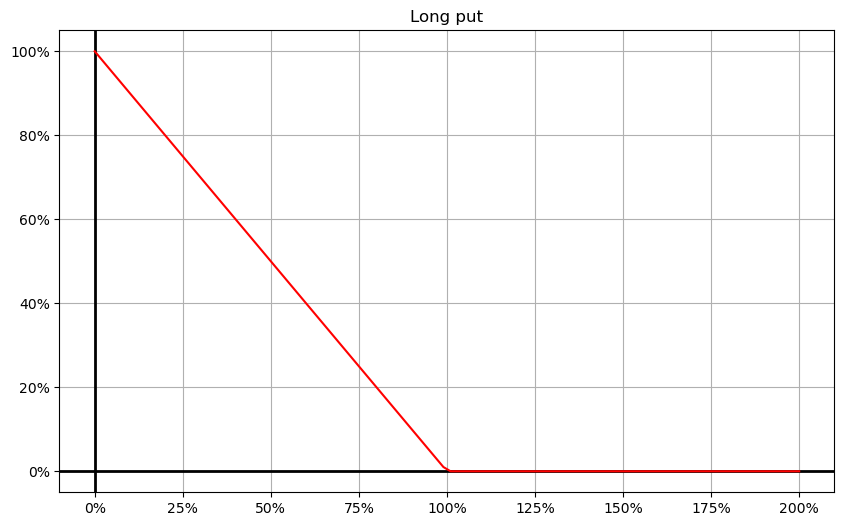

In [161]:
# variables
x = np.linspace(0,2,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)

def exprim_pourcentage(x:float, pos):
    val = x * 100
    return f"{val:.0f}%"

example_price = 0.2

BS = BlackScholes(x,1,0.1,0.05,0.05,1)
y1 = BS.putpayoff() 

# Création de la figure et des sous-graphiques
fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="r")
ax1.set_title('Long put')
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))

## Options Prices and Payoffs

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


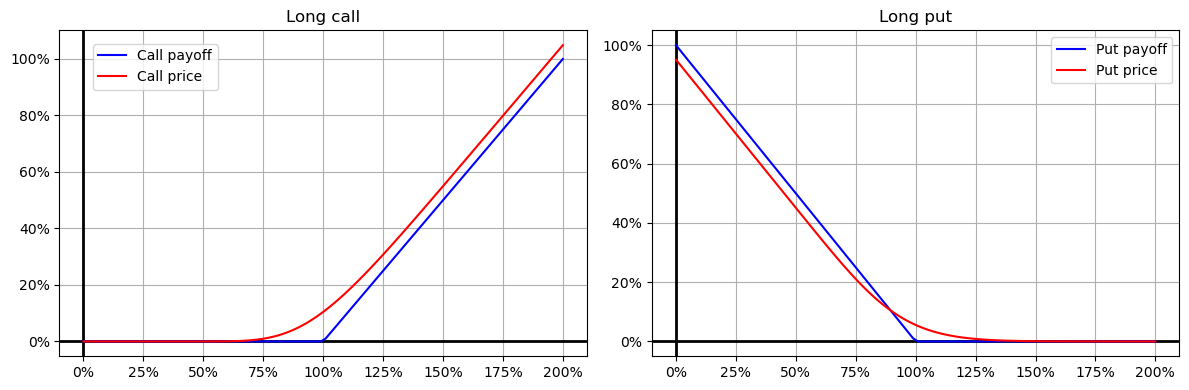

In [163]:
BS = BlackScholes(x,1,0.2,0.05,0,1)
y1 = BS.callpayoff()
y2 = BS.putpayoff()
y3 = BS.callpayoff(False)
y4 = BS.putpayoff(False)

y5 = BS.call()
y6 = BS.put()
y7 = BS.call(False)
y8 = BS.put(False)

# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="b", label = "Call payoff")
ax1.plot(x, y5, c="r", label = "Call price")
ax1.set_title('Long call')
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(x, y2,c="b", label = "Put payoff")
ax2.plot(x, y6,c="r", label = "Put price")
ax2.set_title('Long put')
ax2.grid(True)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))


# Affichage de la figure
plt.tight_layout()
plt.legend()
plt.show()

## Time Value and Intrinsic Value

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


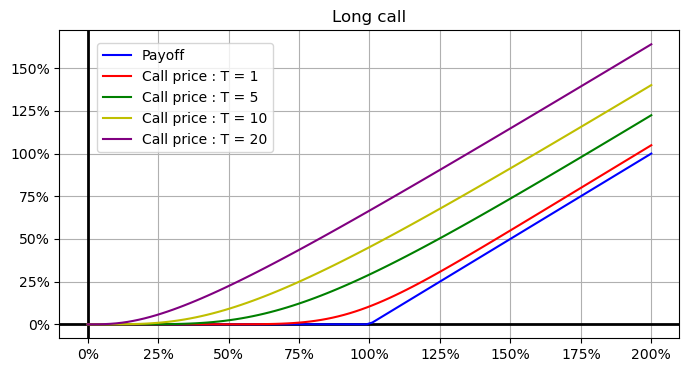

In [6]:
BS1 = BlackScholes(x,1,0.2,0.05,0,1)
y = BS1.callpayoff()
y1 = BS1.call()
BS5 = BlackScholes(x,1,0.2,0.05,0,5)
y2 = BS5.call()
BS10 = BlackScholes(x,1,0.2,0.05,0,10)
y3 = BS10.call()
BS20 = BlackScholes(x,1,0.2,0.05,0,20)
y4 = BS20.call()

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y, c="b", label = "Payoff")
ax1.plot(x, y1, c="r", label = "Call price : T = 1")
ax1.plot(x, y2, c="g", label = "Call price : T = 5")
ax1.plot(x, y3, c="y", label = "Call price : T = 10")
ax1.plot(x, y4, c="purple", label = "Call price : T = 20")
ax1.set_title('Long call')
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

## Parité Call Put

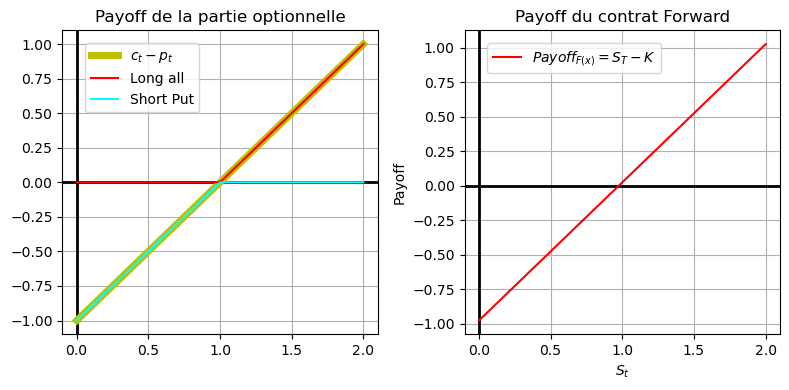

In [9]:
def Forward(S:float, K:float, r:float, T:float):
    Fwd = S-K*np.exp(-r*T)
    return Fwd

# Partie option
BS = BlackScholes(x,1,0.15,0.025,0,1)
call_pcp = BS.callpayoff()
put_pcp = BS.putpayoff(False)
call_put = call_pcp + put_pcp

# Partie Forward
fwd_pcp = Forward(x,1,0.025,1)

# Représentation Graphique : 

# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, call_put, c="y", linewidth=5, linestyle='-', label = r"$c_t - p_t$")
ax1.plot(x, call_pcp, c="r", label = "Long all")
ax1.plot(x, put_pcp, c="cyan", label = "Short Put")
plt.xlabel(r"$S_t$")
plt.ylabel(r"Payoff")

ax1.set_title(r'Payoff de la partie optionnelle')
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(x, fwd_pcp, c="r", label = r"$Payoff_{F(x)} = S_T - K$")
ax2.set_title(r"Payoff du contrat Forward")
ax2.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))
ax2.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()



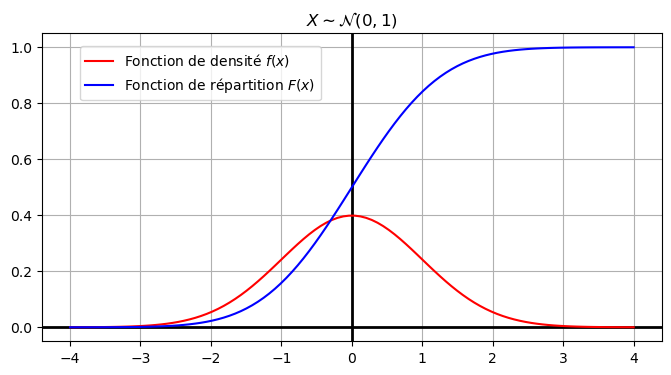

In [12]:
# variables
norm_interval = np.linspace(-4,4,100) # The spot price should be greater than 0, else, it is non-sence
norm_interval = norm_interval.reshape(-1,1)

normal = norm.pdf(norm_interval)
fonct_rep = norm.cdf(norm_interval)

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(norm_interval, normal, c="r", label = r"Fonction de densité $f(x)$")
ax1.plot(norm_interval, fonct_rep, c="b", label = r"Fonction de répartition $F(x)$")
ax1.set_title(r'$X {\sim} \mathcal{N}(0, 1)$')
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))
ax1.grid(True)

## Option's strategy

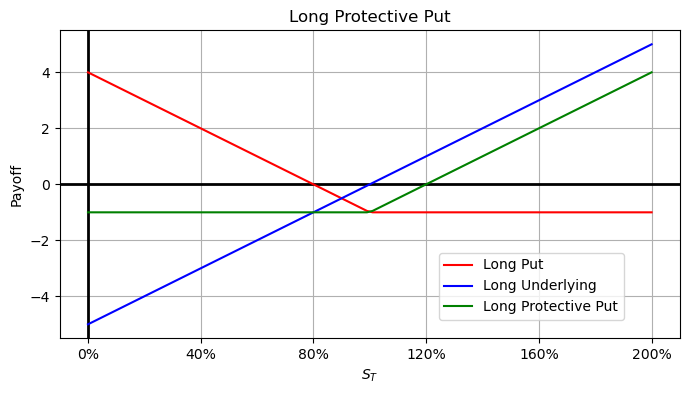

In [154]:
# variables
x = np.linspace(0,10,100)
x = x.reshape(-1,1)

BS = BlackScholes(x,5,0.15,0,0,1)
put = BS.putpayoff() - 1
S = spot(x,5)

covcall = put + S

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, put, c="r", label = r"Long Put")
ax1.plot(x, S, c="b", label = r"Long Underlying")
ax1.plot(x, covcall, c="g", label = r"Long Protective Put")
plt.xlabel(r"$S_T$")
plt.ylabel(r"Payoff")
ax1.set_title("Long Protective Put")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: percent_formatter(x, pos, 5)))
#ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.6, 0.3))

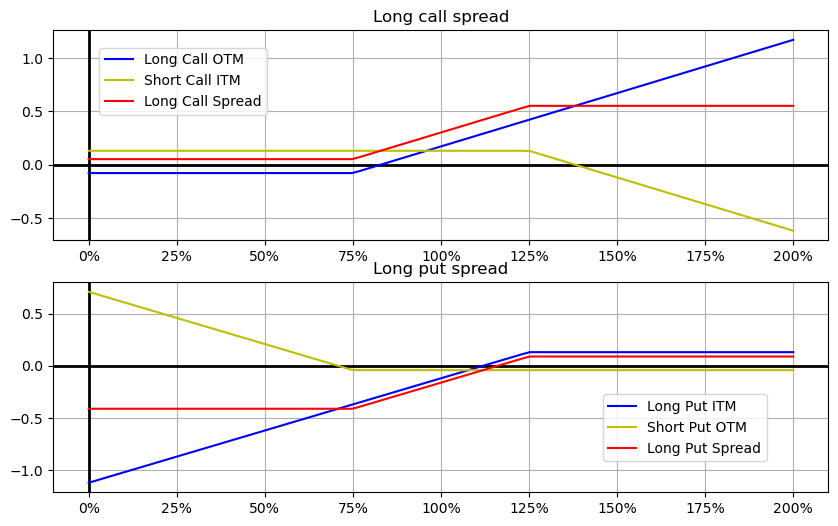

In [153]:
# variables
z = np.linspace(0,2,100)
z = z.reshape(-1,1)

BS = BlackScholes(z,0.75,0.2,0.05,0,1)
y1_c1 = BS.callpayoff() - BlackScholes(0.75,0.75,0.2,0.05,0,1).call() # OTM
y2_p2 = BS.putpayoff() - BlackScholes(0.75,0.75,0.2,0.05,0,1).put() # ITM
BS = BlackScholes(z,1.25,0.2,0.05,0,1)
y2_c2 = BS.callpayoff(False) + BlackScholes(1.25,1.25,0.2,0.05,0,1).call() # ITM
y1_p1 = BS.putpayoff(False) + BlackScholes(1.25,1.25,0.2,0.05,0,1).call() # OTM
yc = y1_c1 + y2_c2
yp = y1_p1 + y2_p2

# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(z, y1_c1, c="b", label = "Long Call OTM")
ax1.plot(z, y2_c2, c="y", label = "Short Call ITM")
ax1.plot(z, yc, c="r", label = "Long Call Spread")
ax1.set_title('Long call spread')
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda z, pos: percent_formatter(z, pos, 1)))
#ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.95))

# Tracé des graphiques à gauche
ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(z, y1_p1, c="b", label = "Long Put ITM")
ax2.plot(z, y2_p2, c="y", label = "Short Put OTM")
ax2.plot(z, yp, c="r", label = "Long Put Spread")
ax2.set_title('Long put spread')
ax2.grid(True)
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(lambda z, pos: percent_formatter(z, pos, 1)))
#ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.legend(loc = "upper left", bbox_to_anchor=(0.7, 0.5))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


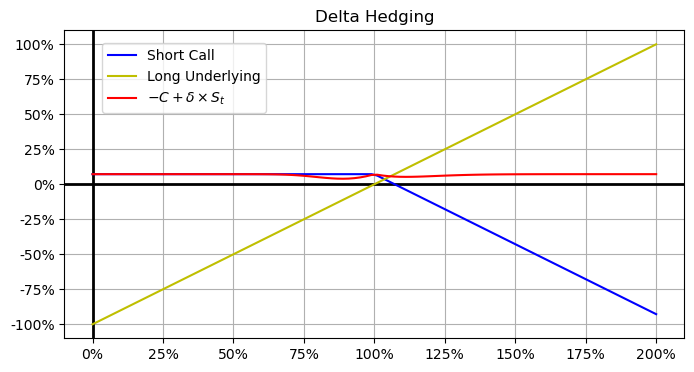

In [14]:
# variables
x = np.linspace(0,2,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)

BS = BlackScholes(x,1,0.15,0.025,0,1)
initial_price = BlackScholes(1,1,0.15,0.025,0,1)
y1 = BS.callpayoff(False) + initial_price.call()
delta = BS.delta()
def spot(x, strike, state : bool = True):
    if state:
        udl = x - strike
    else:
        udl = -(x-strike)
    return udl

y2 = spot(x,1,True)
y3 = y1 + delta * y2


# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="b", label = "Short Call")
ax1.plot(x, y2, c="y", label = "Long Underlying")
ax1.plot(x, y3, c="r", label = r"$-C + \delta \times S_t$")
ax1.set_title('Delta Hedging')
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

## Taylor Formula

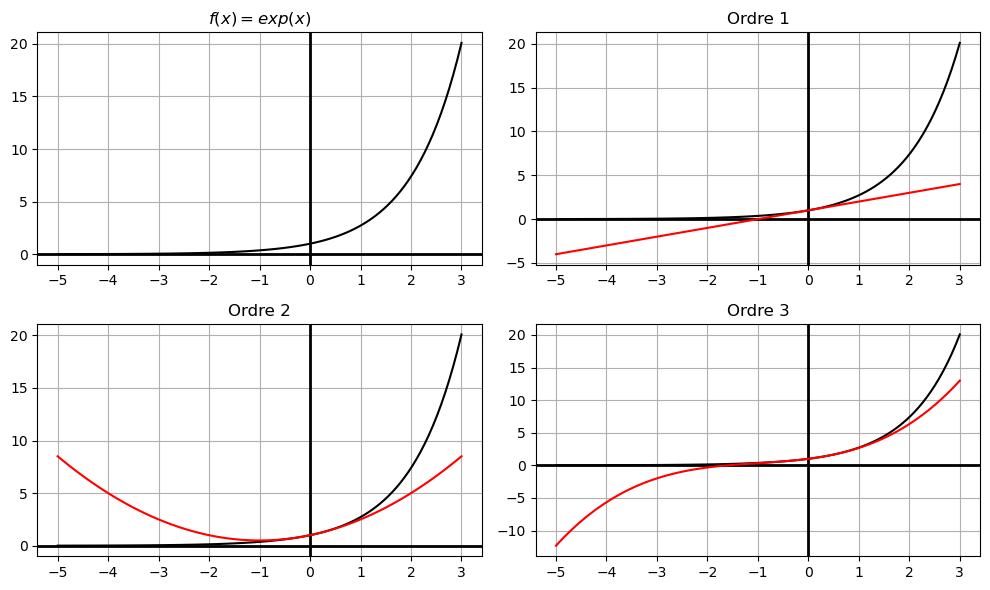

In [16]:
# variables
z = np.linspace(-5,3,100) 
z = z.reshape(-1,1)

fexp = np.exp(z)
fexp1 = 1+z 
fexp2 = 1 + z + (z**2)/2
fexp3 = fexp2 + (z**3)/math.factorial(3)


# Création de la figure et des sous-graphiques
fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(z, fexp, c="black")
ax1.set_title(r'$f(x) = exp(x)$')
ax1.grid(True)

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
ax2.plot(z, fexp, c="black")
ax2.plot(z, fexp1, c="r")
ax2.set_title('Ordre 1')
ax2.grid(True)

ax3.axhline(0, color='black', linewidth=2, linestyle='-')
ax3.axvline(0, color='black', linewidth=2, linestyle='-')
ax3.plot(z, fexp, c="black")
ax3.plot(z, fexp2, c="r")
ax3.set_title('Ordre 2')
ax3.grid(True)

ax4.axhline(0, color='black', linewidth=2, linestyle='-')
ax4.axvline(0, color='black', linewidth=2, linestyle='-')
ax4.plot(z, fexp, c="black")
ax4.plot(z, fexp3, c="r")
ax4.set_title('Ordre 3')
ax4.grid(True)

# Affichage de la figure
plt.tight_layout()
plt.show()

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


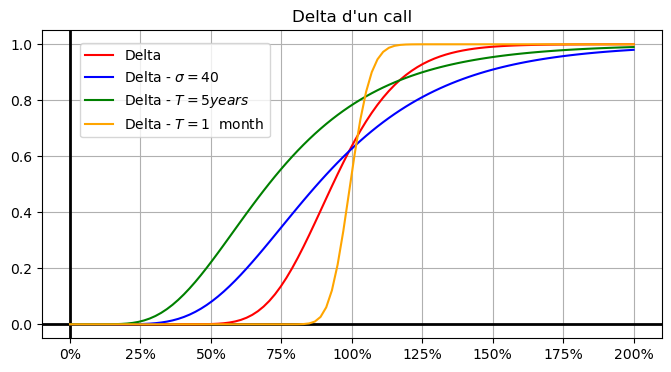

In [17]:
BS = BlackScholes(x,1,0.2,0.05,0,1)
y1 = BS.delta()
BS_vol = BlackScholes(x,1,0.4,0.05,0,1)
y2 = BS_vol.delta()
BS_mat = BlackScholes(x,1,0.2,0.05,0,5)
y3 = BS_mat.delta()
BS_mat_month = BlackScholes(x,1,0.2,0.05,0,1/12)
y4 = BS_mat_month.delta()


# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="r", label = "Delta")
ax1.plot(x, y2, c="b", label = r"Delta - $\sigma = 40%$")
ax1.plot(x, y3, c="g", label = "Delta - $T = 5 years$")
ax1.plot(x, y4, c="orange", label = "Delta - $T = 1$  month")
ax1.set_title("Delta d'un call")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


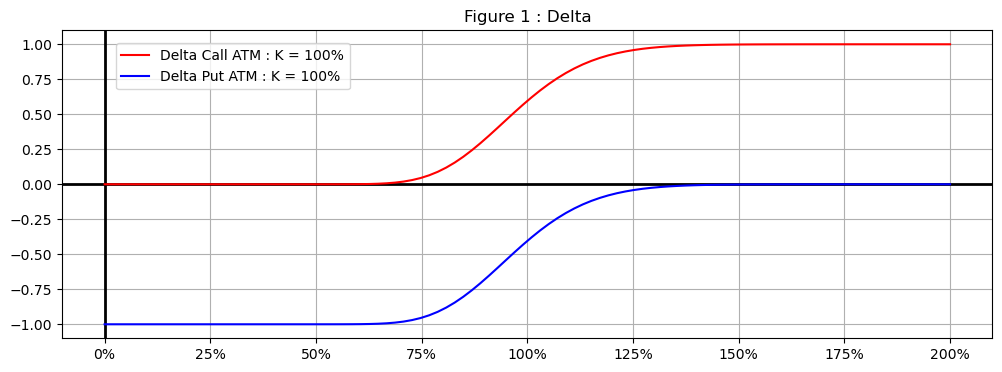

In [98]:
BS = BlackScholes(x,1,0.15,0.025,0,1)
y1 = BS.delta()
y2 = BS.delta(opt = False)

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="r", label = "Delta Call ATM : K = 100%")
ax1.plot(x, y2, c="b", label = "Delta Put ATM : K = 100%")
ax1.set_title("Figure 1 : Delta")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:82: RuntimeWarning: divide by zero encountered in reciprocal
  scal = (self.S * self.sigma * np.sqrt(self.T-t))**(-1)
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:85: RuntimeWarning: invalid value encountered in multiply
  gamma = scal * norm.pdf(d1)


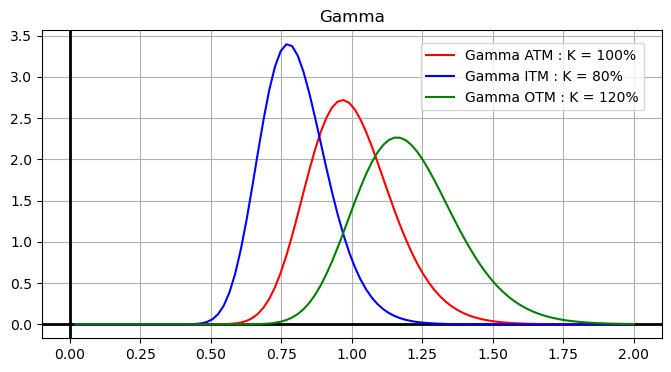

In [20]:
# variables
x = np.linspace(0,2,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)

BS = BlackScholes(x,1,0.15,0,0,1)
gam1 = BS.gamma()
BS_ITM = BlackScholes(x,0.8,0.15,0,0,1)
gam2 = BS_ITM.gamma()
BS_OTM = BlackScholes(x,1.2,0.15,0,0,1)
gam3 = BS_OTM.gamma()

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, gam1, c="r", label = "Gamma ATM : K = 100%")
ax1.plot(x, gam2, c="b", label = "Gamma ITM : K = 80%")
ax1.plot(x, gam3, c="g", label = "Gamma OTM : K = 120%")
ax1.set_title("Gamma")
ax1.grid(True)
#ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.60, 0.98))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:82: RuntimeWarning: divide by zero encountered in reciprocal
  scal = (self.S * self.sigma * np.sqrt(self.T-t))**(-1)
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:85: RuntimeWarning: invalid value encountered in multiply
  gamma = scal * norm.pdf(d1)


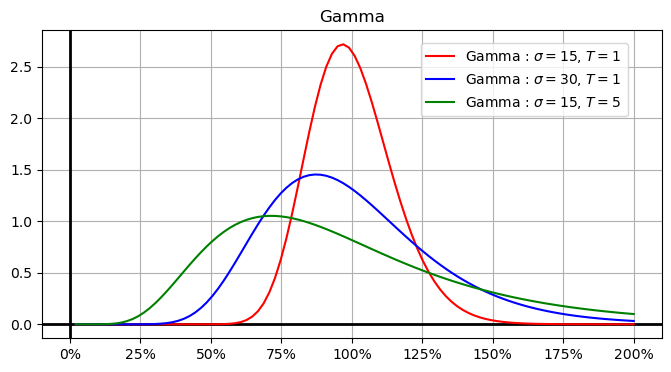

In [21]:
# variables
x = np.linspace(0,2,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)

BS = BlackScholes(x,1,0.15,0,0,1)
y1 = BS.gamma()
BS_vol = BlackScholes(x,1,0.3,0,0,1)
y2 = BS_vol.gamma()
BS_mat = BlackScholes(x,1,0.15,0,0,10)
y3 = BS_mat.gamma()

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="r", label = r"Gamma : $\sigma = 15%$, $T = 1$ ")
ax1.plot(x, y2, c="b", label = r"Gamma : $\sigma = 30%$, $T = 1$ ")
ax1.plot(x, y3, c="g", label = r"Gamma : $\sigma = 15%$, $T = 5$ ")
ax1.set_title("Gamma")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.60, 0.98))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:100: RuntimeWarning: divide by zero encountered in reciprocal
  scal = (self.S * self.sigma * np.sqrt(self.T-t))**(-1)
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:103: RuntimeWarning: invalid value encountered in multiply
  gamma = scal * norm.pdf(d1)


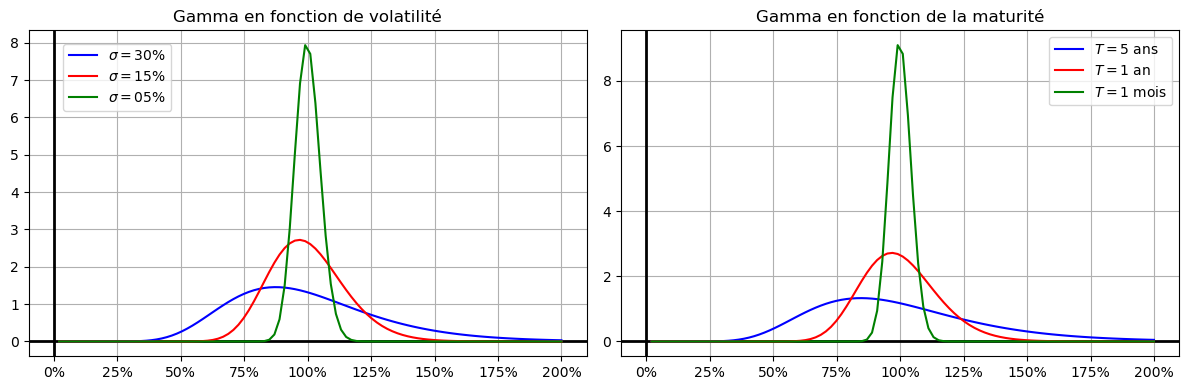

In [115]:
BS = BlackScholes(x,1,0.15,0,0,1)
gam = BS.gamma()

BS_v30 = BlackScholes(x,1,0.3,0,0,1)
gam_v30 = BS_v30.gamma()
BS_vol = BlackScholes(x,1,0.05,0,0,1)
gam_v5 = BS_vol.gamma()

BS_T5 = BlackScholes(x,1,0.15,0,0,5)
gam_T5 = BS_T5.gamma()
BS_T01 = BlackScholes(x,1,0.15,0,0,1/12)
gam_T01 = BS_T01.gamma()


# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, gam_v30, c="b", label = r"$\sigma = 30$%")
ax1.plot(x, gam, c="r", label = r"$\sigma = 15$%")
ax1.plot(x, gam_v5, c="g", label = r"$\sigma = 05$%")
ax1.set_title('Gamma en fonction de volatilité')
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))


ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.plot(x, gam_T5, c="b", label = r"$T = 5$ ans")
ax2.plot(x, gam, c="r", label = r"$T = 1$ an")
ax2.plot(x, gam_T01, c="g", label = r"$T = 1$ mois")
ax2.set_title('Gamma en fonction de la maturité')
ax2.grid(True)


# Affichage de la figure
plt.tight_layout()
plt.legend()
plt.show()

## Mouvement Brownien

Le taux de variation, aussi appelé la dynamique, d'un Mouvement Brownien Géométrique est représenté de la manière suivante
$$
\frac{dS_t}{S_t} = \mu dt + \sigma dW_t
$$

In [23]:
class MBG:
    def __init__(self, S0 : float = 1, K : float = 1, sig : float = 0.2, mu : float = 0.05, T : float = 1):
        self.S0 = S0
        self.K = K
        self.sig = sig
        self.mu = mu
        self.T = T
    
    def wienner(self, N : int = 1000): 
        dt = self.T/N
        W = np.random.standard_normal(size = N+1)
        W = np.cumsum(W) * np.sqrt(dt)        
        return W
    
    def gen_MBG(self, N : int = 1000):
        dt = self.T/N
        W = self.wienner(N)
        S = self.S0 * np.exp((self.mu - 0.5 * self.sig**2)*dt + (self.sig * W))
        return S

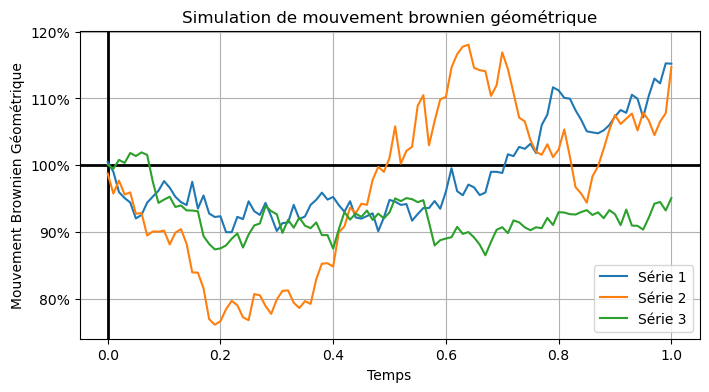

In [24]:
N = 100
T = 1
t = np.linspace(0, T, N+1)  # Grille de temps

Brown = MBG()
np.random.seed(34)
path_1 = Brown.gen_MBG(N)
Brown_2 = MBG(sig = 0.25)
path_2 = Brown_2.gen_MBG(N)
Brown_3 = MBG(mu = -0.2, sig = 0.15)
path_3 = Brown_3.gen_MBG(N)

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Afficher le mouvement brownien géométrique
ax1.axhline(1, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
plt.plot(t, path_1, label = "Série 1")
plt.plot(t, path_2, label = "Série 2")
plt.plot(t, path_3, label = "Série 3")
plt.xlabel('Temps')
plt.ylabel('Mouvement Brownien Géométrique')
plt.title('Simulation de mouvement brownien géométrique')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
plt.grid(True)
plt.legend()
plt.show()


In [25]:
delt_1 = []
delt_2 = []
delt_3 = []
K = 1
sig = 0.15
r = 0.05
q = 0
T = 1
count_1 = 0
for path in path_1:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_1]
    count_1 += 1
    delt = BS.delta(t = time)
    delt_1.append(delt)

    
count_2 = 0    
for path in path_2:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_2]
    count_2 += 1
    delt = BS.delta(t = time)
    delt_2.append(delt)
    

count_3 = 0    
for path in path_3:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_3]
    count_3 += 1
    delt = BS.delta(t = time)
    delt_3.append(delt)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


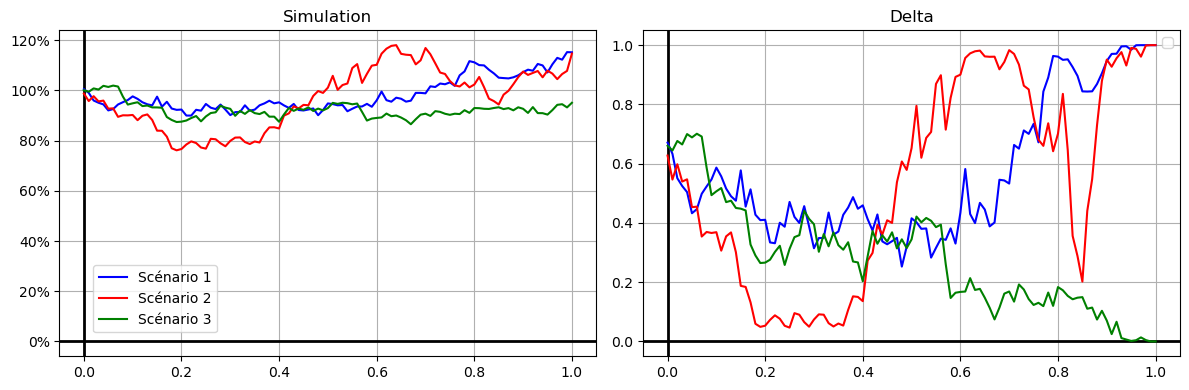

In [26]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(t, path_1, c="b", label = "Scénario 1")
ax1.plot(t, path_2, c="r", label = "Scénario 2")
ax1.plot(t, path_3, c="g", label = "Scénario 3")
ax1.set_title('Simulation')
ax1.grid(True)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.3))


ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.plot(t, delt_1,c="b")
ax2.plot(t, delt_2,c="r")
ax2.plot(t, delt_3,c="g")
ax2.set_title('Delta')
ax2.grid(True)


# Affichage de la figure
plt.tight_layout()
plt.legend()
plt.show()

In [27]:
def delta_udl(index:float, h:float):
    udl = spot(x, 1)
    delta = (spot(x+h,1) - spot(x,1))/h
    ind = np.round(index,0)
    return float(np.round(delta[int(ind)],1))

In [28]:
gamma_1 = []
gamma_2 = []
gamma_3 = []
K = 1
sig = 0.15
r = 0.05
q = 0
T = 1
count_1 = 0
for path in path_1:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_1]
    count_1 += 1
    gamm = BS.gamma(t = time)
    gamma_1.append(gamm)

    
count_2 = 0    
for path in path_2:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_2]
    count_2 += 1
    gamm = BS.gamma(t = time)
    gamma_2.append(gamm)

count_3 = 0    
for path in path_3:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_3]
    count_3 += 1
    gamm = BS.gamma(t = time)
    gamma_3.append(gamm)


C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:82: RuntimeWarning: divide by zero encountered in double_scalars
  scal = (self.S * self.sigma * np.sqrt(self.T-t))**(-1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


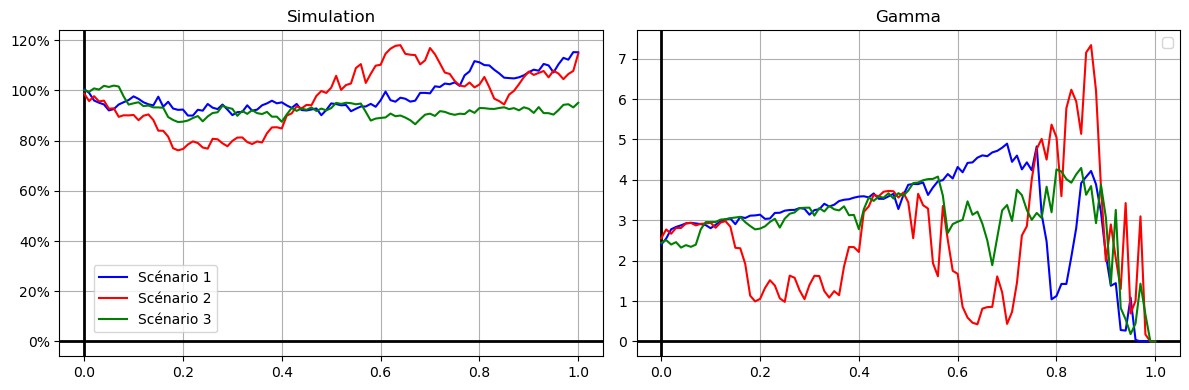

In [29]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(t, path_1, c="b", label = "Scénario 1")
ax1.plot(t, path_2, c="r", label = "Scénario 2")
ax1.plot(t, path_3, c="g", label = "Scénario 3")
ax1.set_title('Simulation')
ax1.grid(True)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.3))

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.plot(t, gamma_1,c="b")
ax2.plot(t, gamma_2,c="r")
ax2.plot(t, gamma_3,c="g")
ax2.set_title('Gamma')
ax2.grid(True)


# Affichage de la figure
plt.tight_layout()
plt.legend()
plt.show()

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:15: RuntimeWarning: invalid value encountered in true_divide
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:15: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


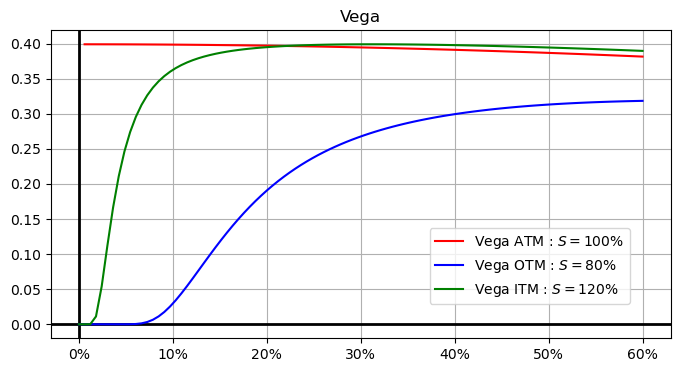

In [155]:
# variables
x = np.linspace(0,0.6,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)

BS = BlackScholes(1,1,x,0,0,1)
Veg1 = BS.vega()
BS_OTM = BlackScholes(0.8,1,x,0,0,1)
Veg2 = BS_OTM.vega()
BS_ITM = BlackScholes(1.05,1,x,0,0,1)
Veg3 = BS_ITM.vega()

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, Veg1, c="r", label = r"Vega ATM : $S = 100$%")
ax1.plot(x, Veg2, c="b", label = r"Vega OTM : $S = 80$%")
ax1.plot(x, Veg3, c="g", label = r"Vega ITM : $S = 120$%")
ax1.set_title("Vega")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.60, 0.38))

In [31]:
import matplotlib.ticker as ticker

In [32]:
def percent_formatter(x, pos, y):
    percent = (x / y) * 100
    return f'{percent:.0f}%'


C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


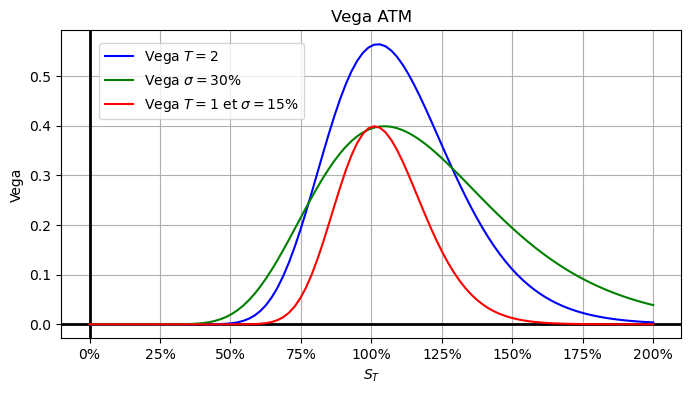

In [114]:
# variables
x = np.linspace(0,2,100)
x = x.reshape(-1,1)

BS = BlackScholes(x,1,0.15,0,0,1)
y1 = BS.vega()
BS_OTM = BlackScholes(x,1,0.15,0,0,2)
y2 = BS_OTM.vega()
BS_ITM = BlackScholes(x,1,0.3,0,0,1)
y3 = BS_ITM.vega()

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y2, c="b", label = r"Vega $T = 2$")
ax1.plot(x, y3, c="g", label = r"Vega $\sigma = 30$%")
ax1.plot(x, y1, c="r", label = r"Vega $T=1$ et $\sigma = 15$%")
plt.xlabel(r"$S_T$")
plt.ylabel(r"Vega")
ax1.set_title("Vega ATM")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: percent_formatter(x, pos, 1)))
#ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1815821929.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


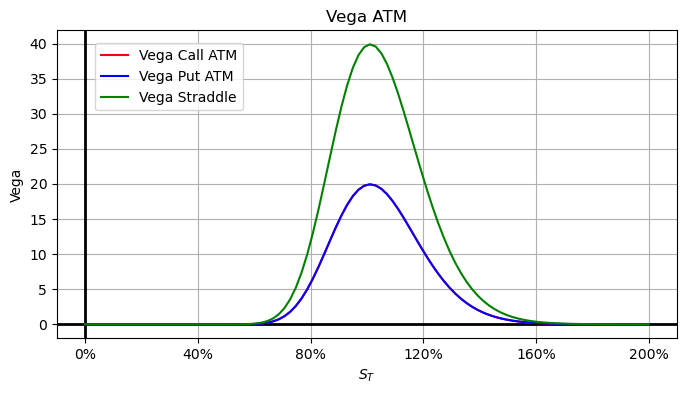

In [86]:
# variables
x = np.linspace(0,100,100)
x = x.reshape(-1,1)

BS = BlackScholes(x,50,0.15,0,0,1)
call = BS.vega()
put = BS.vega()

straddle_vega = call + put
#BS_OTM = BlackScholes(x,0.8,0.15,0,0,1)
#y2 = BS_OTM.vega()
#BS_ITM = BlackScholes(x,1.2,0.15,0,0,1)
#y3 = BS_ITM.vega()

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, call, c="r", label = r"Vega Call ATM")
ax1.plot(x, put, c="b", label = r"Vega Put ATM")
ax1.plot(x, straddle_vega, c="g", label = r"Vega Straddle")
plt.xlabel(r"$S_T$")
plt.ylabel(r"Vega")
ax1.set_title("Vega ATM")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: percent_formatter(x, pos, 50)))
#ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:15: RuntimeWarning: invalid value encountered in true_divide
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\2629724998.py:15: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


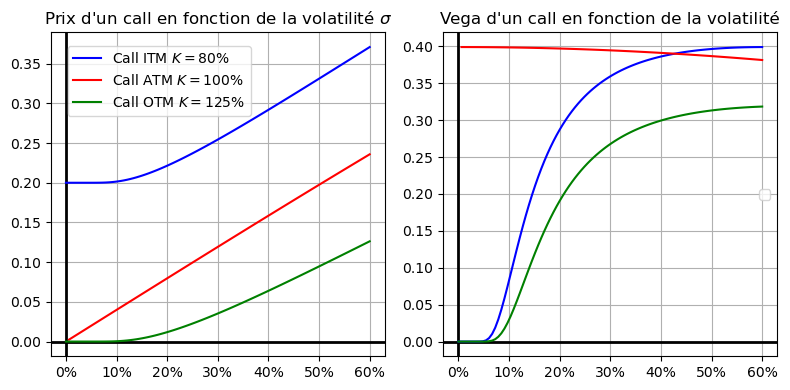

In [107]:
# variables
z = np.linspace(0,0.6,100)
z = z.reshape(-1,1)


# Etude prix option

BS_ATM = BlackScholes(1,1,z,0,0,1)
callatm = BS_ATM.call()
vegcallatm = BS_ATM.vega()
BS_OTM = BlackScholes(0.8,1,z,0,0,1)
callotm = BS_OTM.call()
vegcallotm = BS_OTM.vega()
BS_ITM = BlackScholes(1.2,1,z,0,0,1)
callitm = BS_ITM.call()
vegcallitm = BS_ITM.vega()


# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(z, callitm, c="b", label = r"Call ITM $ K = 80$%")
ax1.plot(z, callatm, c="r", label = r"Call ATM $K = 100$%")
ax1.plot(z, callotm, c="g", label = r"Call OTM $K = 125$%")
ax1.set_title(r"Prix d'un call en fonction de la volatilité $\sigma$")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.03, 0.98))

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.plot(z, vegcallitm,c="b")
ax2.plot(z, vegcallatm,c="r")
ax2.plot(z, vegcallotm,c="g")
ax2.set_title("Vega d'un call en fonction de la volatilité")
ax2.grid(True)


# Affichage de la figure
plt.tight_layout()
plt.legend()
plt.show()

In [35]:
veg1 = []
veg2 = []
veg3 = []
K = 1
sig = 0.15
r = 0.05
q = 0
T = 1
count_1 = 0
for path in path_1:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_1]
    count_1 += 1
    veg = BS.vega(t = time)
    veg1.append(veg)

    
count_2 = 0    
for path in path_2:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_2]
    count_2 += 1
    veg = BS.vega(t = time)
    veg2.append(veg)

count_3 = 0    
for path in path_3:
    BS = BlackScholes(path, K, sig, r, q, T)
    time = t[count_3]
    count_3 += 1
    veg = BS.vega(t = time)
    veg3.append(veg)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


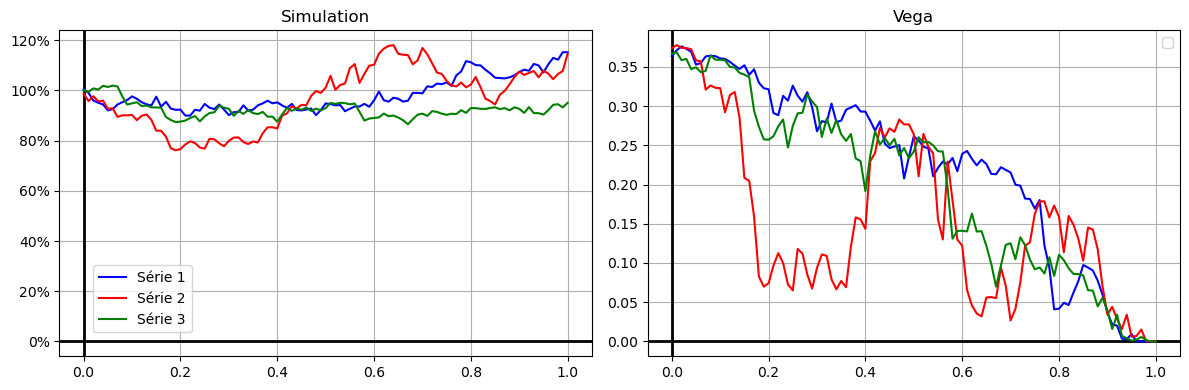

In [36]:
# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(t, path_1, c="b", label = "Série 1")
ax1.plot(t, path_2, c="r", label = "Série 2")
ax1.plot(t, path_3, c="g", label = "Série 3")
ax1.set_title('Simulation')
ax1.grid(True)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.3))

ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
#ax2.yaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.plot(t, veg1,c="b")
ax2.plot(t, veg2,c="r")
ax2.plot(t, veg3,c="g")
ax2.set_title('Vega')
ax2.grid(True)


# Affichage de la figure
plt.tight_layout()
plt.legend()
plt.show()

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: invalid value encountered in true_divide
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


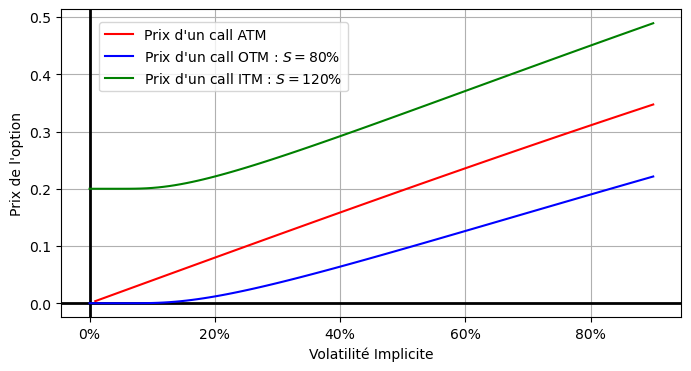

In [37]:
# variables
x = np.linspace(0,0.9,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)

BS = BlackScholes(1,1,x,0,0,1)
y1 = BS.call()
BS_OTM = BlackScholes(0.8,1,x,0,0,1)
y2 = BS_OTM.call()
BS_ITM = BlackScholes(1.2,1,x,0,0,1)
y3 = BS_ITM.call()

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="r", label = r"Prix d'un call ATM")
ax1.plot(x, y2, c="b", label = r"Prix d'un call OTM : $S = 80$%")
ax1.plot(x, y3, c="g", label = r"Prix d'un call ITM : $S = 120$%")
ax1.set_title("")
plt.ylabel("Prix de l'option")
plt.xlabel("Volatilité Implicite")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


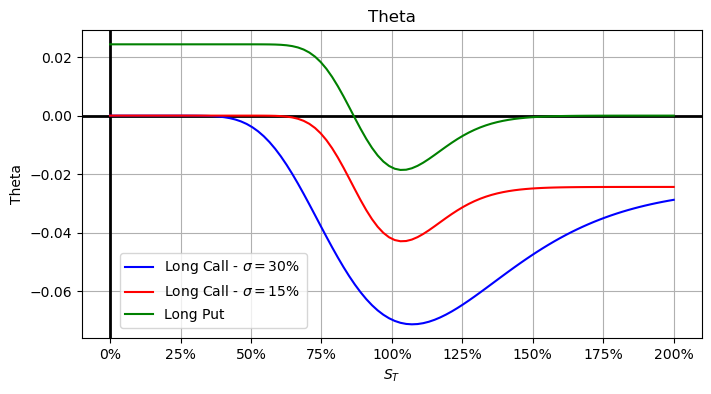

In [38]:
# variables
x = np.linspace(0,2,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)


BS = BlackScholes(x,1,0.15,0.025,0,1)
theta_atm_call = BS.theta()
theta_atm_put = BS.theta(opt = False)
BS = BlackScholes(x,1,0.3,0.025,0,1)
theta_atm_call_vol = BS.theta()


# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, theta_atm_call_vol, c="b", label = r"Long Call - $\sigma = 30$% ")
ax1.plot(x, theta_atm_call, c="r", label = r"Long Call - $\sigma = 15$%")
ax1.plot(x, theta_atm_put, c="g", label = r"Long Put")
ax1.set_title("Theta")
plt.xlabel(r"$S_T$")
plt.ylabel("Theta")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: percent_formatter(x, pos, 1)))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.3))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1451855716.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))


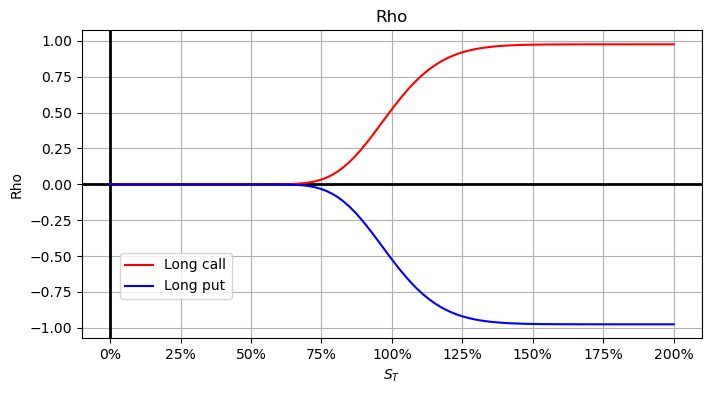

In [39]:
# variables
x = np.linspace(0,2,100) # The spot price should be greater than 0, else, it is non-sence
x = x.reshape(-1,1)


BS = BlackScholes(x,1,0.15,0.025,0,1)
rho_atm_call = BS.rho()
rho_atm_put = BS.rho(opt = False)

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, rho_atm_call, c="r", label = "Long call")
ax1.plot(x, rho_atm_put, c="b", label = "Long put")
ax1.set_title("Rho")
plt.xlabel(r"$S_T$")
plt.ylabel("Rho")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: percent_formatter(x, pos, 1)))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.3))

### Volga

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\3223675462.py:15: RuntimeWarning: invalid value encountered in true_divide
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\3223675462.py:15: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\3223675462.py:159: RuntimeWarning: invalid value encountered in multiply
  volg = np.exp(-self.q * t) * np.sqrt(self.T - t) * norm.pdf(d1) * (d1*d2)/self.sigma
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


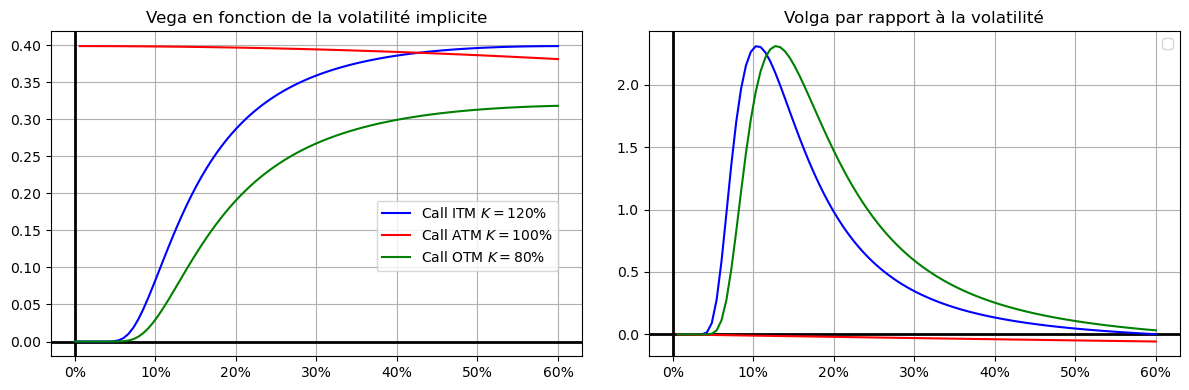

In [49]:
# variables
z = np.linspace(0,0.6,100)
z = z.reshape(-1,1)


# Etude prix option

BS_ATM = BlackScholes(1,1,z,0,0,1)
vegcallatm = BS_ATM.vega()
volgcallatm = BS_ATM.volga()
BS_OTM = BlackScholes(0.8,1,z,0,0,1)
vegcallotm = BS_OTM.vega()
volgcallotm = BS_OTM.volga()
BS_ITM = BlackScholes(1.2,1,z,0,0,1)
vegcallitm = BS_ITM.vega()
volgcallitm = BS_ITM.volga()


# Création de la figure et des sous-graphiques
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(z, vegcallitm, c="b", label = r"Call ITM $ K = 120$%")
ax1.plot(z, vegcallatm, c="r", label = r"Call ATM $K = 100$%")
ax1.plot(z, vegcallotm, c="g", label = r"Call OTM $K = 80$%")
ax1.set_title(r"Vega en fonction de la volatilité implicite")
ax1.legend(loc = "upper left", bbox_to_anchor=(0.6, 0.5))
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))


ax2.axhline(0, color='black', linewidth=2, linestyle='-')
ax2.axvline(0, color='black', linewidth=2, linestyle='-')
ax2.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax2.plot(z, volgcallitm,c="b")
ax2.plot(z, volgcallatm,c="r")
ax2.plot(z, volgcallotm,c="g")
ax2.set_title("Volga par rapport à la volatilité")
ax2.grid(True)


# Affichage de la figure
plt.tight_layout()
plt.legend()
plt.show()

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1815821929.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1815821929.py:159: RuntimeWarning: invalid value encountered in multiply
  volg = np.exp(-self.q * t) * np.sqrt(self.T - t) * norm.pdf(d1) * (d1*d2)/self.sigma


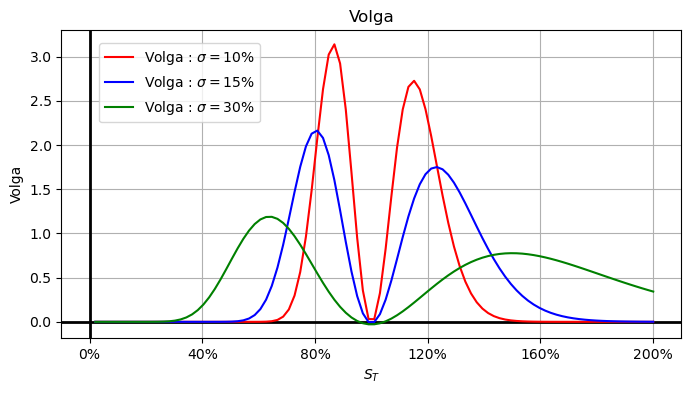

In [84]:
# variables
x = np.linspace(0,100,100)
x = x.reshape(-1,1)

BS = BlackScholes(x,50,0.1,0,0,1)
y1 = BS.volga()
BS_vol15 = BlackScholes(x,50,0.15,0,0,1)
y2 = BS_vol15.volga()
BS_vol30 = BlackScholes(x,50,0.3,0,0,1)
y3 = BS_vol30.volga()

# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="r", label = r"Volga : $\sigma = 10$%")
ax1.plot(x, y2, c="b", label = r"Volga : $\sigma = 15$%")
ax1.plot(x, y3, c="g", label = r"Volga : $\sigma = 30$%")
plt.xlabel(r"$S_T$")
plt.ylabel(r"Volga")
ax1.set_title("Volga")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: percent_formatter(x, pos, 50)))
#ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))
ax1.legend(loc = "upper left", bbox_to_anchor=(0.05, 0.98))

C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1815821929.py:15: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(self.S/self.K)+(self.r -self.q + self.sigma**(2) /2)*(self.T - t))/(self.sigma* np.sqrt(self.T-t))
C:\Users\milan\AppData\Local\Temp\ipykernel_18272\1815821929.py:170: RuntimeWarning: invalid value encountered in multiply
  van = np.exp(-self.q*t) * np.sqrt(self.T-t) * norm.pdf(d1) * d2/self.sigma


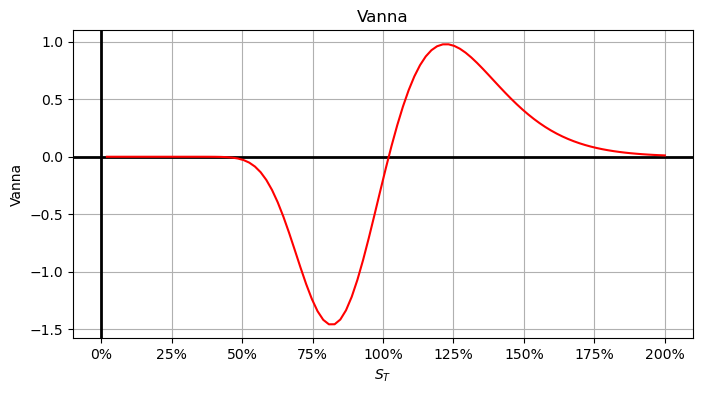

In [81]:
# variables
x = np.linspace(0,2,100)
x = x.reshape(-1,1)

BS = BlackScholes(x,1,0.2,0,0,1)
y1 = BS.vanna()


# Création de la figure et des sous-graphiques
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Tracé des graphiques à gauche
ax1.axhline(0, color='black', linewidth=2, linestyle='-')
ax1.axvline(0, color='black', linewidth=2, linestyle='-')
ax1.plot(x, y1, c="r")
plt.xlabel(r"$S_T$")
plt.ylabel(r"Vanna")
ax1.set_title("Vanna")
ax1.grid(True)
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: percent_formatter(x, pos, 1)))
#ax1.xaxis.set_major_formatter(ticker.FuncFormatter(exprim_pourcentage))